# TensorFlow Feature Column

텐서플로에서는 [`tf.feature_column`](https://www.tensorflow.org/guide/feature_columns)을 이용해 모델에 맞게 데이터를 변형하거나, 데이터의 형식을 지정해줄 수 있다. 이러한 `tf.feature_column`을 통해 처리한 데이터를 `Estimator`([여기](http://excelsior-cjh.tistory.com/157?category=940399) 참고)에 쉽게 적용하여 모델링 할 수 있다. 

이번 포스팅에서는 텐서플로의 `feature_column`을 이용해 데이터를 처리하는 방법과 `Estimator`가 아닌 텐서플로의 **Low-Level API**를 이용해 `feature_column`의 결과가 어떠한 모양을 가지는지, 그리고 여러개의 범주형 데이터에 대한 입력층(input layer)의 형태는 어떠한지에 대해 알아보도록 하자.



먼저, 데이터의 종류에는 어떤 것이 있으며, Feature Engineering, 그리고 범주형 데이터의 표현방법에 대해 살펴보자.

## SetUp

In [1]:
import os
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

## 1. Feature Engineering 이란

데이터는 아래의 그림처럼 크게 **범주형 데이터**(Categorical, qualitative)와 **수치형 데이터**(Numerical, quantitative)로 나눌 수 있다.

![](./images/data.png)

이러한 데이터의 형식을 머신러닝/딥러닝 모델에 맞게 데이터를 **표현**(data representation)하는 것이 중요하며, 적합한 데이터의 표현을 찾는 것을 **Feature Engineering**(특성 공학)이라고 한다.

### 1.1 One-Hot-Encoding (가변수, dummy variable)

범주형 변수를 표현하는데 가장 많이 쓰이는 방법은 **원-핫-인코딩(one-hot-encoding)**이다. 원-핫-인코딩을 **가변수(dummy variable)**이라고도 하는데, 범주형 변수를 0 또는 1 값을 가지는 새로운 특성으로 바꾸는 것을 말한다.  

예를 들어, 아래의 그림처럼 'color'라는 특성에서 'red, green, blue'의 범주형 데이터를 원-핫-인코딩을 적용하면 각 색깔에 해당하는 부분에는 '1'을 나머지 부분을 '0'으로 바꿔 3개의 특성으로 나타낼 수 있다.

![](./images/one-hot.png)

#### pandas의 get_dummies()를 이용한 one-hot-encoding

`pandas`의 `get_dummies()` 함수를 이용해 간편하게 원-핫-인코딩 할 수 있다. `get_dummies()`함수는 문자열 같은 `object` 나 `category` 타입의 데이터를 자동으로 원-핫-인코딩 해준다.

In [2]:
import pandas as pd

colors = ['red', 'green', 'blue', 'red']

df = pd.DataFrame(colors, columns=['color'])
df_dummies = pd.get_dummies(df)
display(df)
display(df_dummies)

,color
0,red
1,green
2,blue
3,red


,color_blue,color_green,color_red
0,0,0,1
1,0,1,0
2,1,0,0
3,0,0,1


#### Scikit-Learn의 OneHotEncoder 이용한 one-hot-encoding

scikit-learn의 `OneHotEncoder`를 사용하여 원-핫-인코딩을 해줄 수 있다. 하지만, `OneHotEncoder`는 `int` 형식의 `array`를 입력값으로 받기 때문에, `LabelEncoder`를 이용해 문자열(`str`) 타입인 색깔을 `int` 로 인덱싱 해준 후에 `OneHotEncoder`로 원-핫-인코딩 해줘야 한다.

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# str -> int : indexing
le = LabelEncoder( ).fit(colors)
le_color = le.transform(colors)
le_color = le_color.reshape(-1, 1)

# indexing -> one-hot
ohe = OneHotEncoder(sparse=False).fit(le_color)
ohe_color = ohe.transform(le_color)
print(ohe_color)

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


#### TensorFlow의 keras.utils.to_categorical()을 이용한 one-hot-encoding

TensorFlow의 `tf.keras.utils.to_categorical()`을 이용해 원-핫-인코딩을 해줄 수 있다. `to_categorical()` 또한,  `int` 형식의 `array`를 입력값으로 받기 때문에, `LabelEncoder`를 이용해 문자열(`str`) 타입인 색깔을 `int` 로 인덱싱 해준 후에 `OneHotEncoder`로 원-핫-인코딩 해준다.

In [4]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# str -> int : indexing
le = LabelEncoder( ).fit(colors)
le_color = le.transform(colors)
le_color = le_color.reshape(-1, 1)

# indexing -> one-hot
ohe_color = tf.keras.utils.to_categorical(le_color)
print(ohe_color)

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


### 1.2 구간 분할(Binning), 이산화(Discretization)

선형 모델(linear model)은 선형 관계로만 모델링하므로 특성(feature)이 하나일 때에는 직선으로 적합(fitting)된다. 이러한 선형모델을 더 좋게, 강력하게 모델링하기 위해서는 수치형 데이터인 하나의 특성을 일정한 구간으로 분할하여 여러개의 특성으로 만들어 주는 방법이 있다. 이러한 방법을 **구간 분할(binning)** 또는 이산화(discretization)라고 한다. 즉, 수치형 데이터를 구간 분할을 통해 범주형 데이터로 바꿔주는 것이다.

아래의 예제는 Scikit-Learn의 `LinearRegression`을 이용해 샘플 데이터셋에 적용한 것과 구간 분할 후 데이터가 어느 구간에 속하는지 원-핫-인코딩을 이용해 변환한 다음 `LinearRegression`을 적용한 것을 비교한 코드이다.

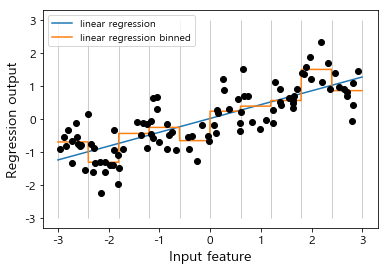

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# create sample dataset
def make_wave(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=(len(x)))) / 2
    return x.reshape(-1, 1), y


X, y = make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

#######################
# 1. LinearRegression #
#######################
reg = LinearRegression().fit(X, y)


#####################################
# 2. LinearRegression after binning #
#####################################
# binning
bins = np.linspace(-3, 3, 11)
# print("bins: {}".format(bins))

# 데이터가 어느 구간에 속하는지 labeling
which_bin = np.digitize(X, bins=bins)
# print("\n Data points: \n", X[:5])
# print("\n 데이터 포인트의 소속 구간: \n", which_bin[:5])

encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
# One-hot encoding으로 변환
X_binned = encoder.transform(which_bin)
# print(X_binned[:5])

line_binned = encoder.transform(np.digitize(line, bins=bins))

reg_ohe = LinearRegression().fit(X_binned, y)

plt.plot(line, reg.predict(line), label='linear regression')
plt.plot(line, reg_ohe.predict(line_binned), 
         label='linear regression binned')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(bins, -3, 3, linewidth=1, alpha=.2)
plt.ylabel("Regression output")
plt.xlabel('Input feature')
plt.legend(loc='best');

### 1.3 특성 교차(Feature Cross)

**특성 교차(feature cross)**는 두 개 이상의 특성(feature)들을 곱하여 새로운 특성을 만드는 방법이다. 특성 교차는 아래의 그림과 같이 비선형(non-linear) 문제를 해결할 수 있는 방법 중 하나로 사용할 수 있다.  아래의 왼쪽 그림에서 선형으로 분리할 수 없었던 문제를 $x_3 = x_1 x_2$ 특성 교차를 추가해 줌으로써 **비선형 문제를 선형모델로 학습**시킬 수 있게 된다.


$$
y = b + w_1x_2 + w_2x_2 + w_3x_3
$$


![](./images/feature_cross.png)

#### 범주형 데이터의 특성 교차

특성 교차는 범주형(categorical) 데이터에도 사용할 수 있다. 아래의 그림은 [California Housing Price 데이터셋](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)에 서 위도(latitude)와 경도('longitude')를 각각 5개의 구간으로 분할(binning)한 뒤 특성 교차를 적용한 것으로 노란색 박스 부분을 원-핫-인코딩으로 나타내면 다음과 같이 나타낼 수 있다.

```
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ← (5 x 5)
```

![](./images/cf-03.png)

#### 특성 교차의 임베딩(Embedding)

위에서 그림에서 처럼 위도(latitude)와 경도('longitude')를 각각 5개의 구간으로 분할(binning)한 뒤 특성 교차를 이용해 노란색 박스 부분을 원-핫-인코딩으로 나타내면 25차원 중 하나만 '1'이고 나머지 24개는 '0'인 스파스(Sparse)한 데이터로 표현된다(sparse representation). 만약, 범주형 데이터의 차원이 커질수록 특성교차의 원-핫-인코딩은 더욱 Sparse해진다.  이러한 문제를 해결하기 위해 원-핫-인코딩이 아닌 저차원으로 매핑해주는 **임베딩**(embedding)을 이용한다.

![](./images/cf-04.png)

## 2. TensorFlow Feature Column

텐서플로에서는 [`tf.feature_column`](https://www.tensorflow.org/guide/feature_columns)을 이용해 위에서 살펴본 Feature Engineering 방법들을 적용할 수 있다.    `tf.feature_column`은 크게 `CategoricalColumn`과 `DenseColumn`으로 이루어져 있으며 이 둘을 동시에 상속받는 `bucketized_column`이 있다.

![](./images/feature_column.PNG)

### 2.1 categorical_column_with_vocabulary_list

`tf.feature_column.categorical_column_with_vocabulary_list()`는  `str`로 구성된 리스트를 범주형 데이터로 나타낸다. `categorical_column_with_vocabulary_list()`를 사용하기 위해서는 나중에 살펴볼 `indicator_column ` 을 이용해 **Multi-hot**-encoding으로 wrapping하거나,  `embedding_column`을 이용해 저차원으로 임베딩으로 wrapping 해줘야 한다.

In [24]:
# categorical variable
programming = tf.feature_column.categorical_column_with_vocabulary_list(
    key='programming',
    vocabulary_list=['Python', 'Java', 'C++'])

# multi-hot-encoding
programming_mh = tf.feature_column.indicator_column(programming)

feature_columns = [programming_mh]
features = {
    'programming': ['Python', 'Java', 'C++'],
}

# input value
input_layer = tf.feature_column.input_layer(
    features=features,
    feature_columns=feature_columns)

# 결과값 확인
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.tables_initializer().run()
    inputs = input_layer.eval()
    
print(inputs)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### 2.2 indicator_column

`tf.feature_column.indicator_column()`은 범주형 데이터를 **멀티-핫-인코딩**(multi-hot)으로 나타낸다.  아래의 예제는 2.1의 예제를 이어서 `['Python', 'Python', 'C++']` 을 멀티-핫-인코딩 해준 코드이다.

In [26]:
feature_columns = [programming_mh]
features = {
    'programming': [['Python', 'Python', 'C++']],
}

# input value
input_layer = tf.feature_column.input_layer(
    features=features,
    feature_columns=feature_columns)

# 결과값 확인
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.tables_initializer().run()
    inputs = input_layer.eval()
    
print(inputs)

[[2. 0. 1.]]


### 2.3 numeric_column

`tf.feature_column.numeric_column()` 은 수치형 데이터(numerical)를 나타낸다. 

이제부터 나오는 예제들은  [California Housing Price 데이터셋](http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) 을 가지고 작성한 코드이다. 해당 데이터셋은 아래의 코드를 통해 확인할 수 있다.


In [1]:
import pandas as pd
import tensorflow as tf

cf_housing_df = pd.read_csv('https://storage.googleapis.com/mledu-datasets/california_housing_train.csv')
cf_housing_df['median_house_value'] = cf_housing_df['median_house_value'] / 1000.0
cf_housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66.9
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80.1
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85.7
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73.4
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65.5


아래의 코드는 위도(latitude)와 경도(longitude)를 `numeric_column()`을 이용해 수치형 데이터로 나타낸 것이다.

In [27]:
longitude = tf.feature_column.numeric_column("longitude")
latitude = tf.feature_column.numeric_column("latitude")

feature_columns = [longitude,latitude]
features = {
    'longitude': [-114.31],
    'latitude': [34.19]
}

input_layer = tf.feature_column.input_layer(
    features=features,
    feature_columns=feature_columns)

with tf.Session() as sess:
    inputs = input_layer.eval()
    
print(inputs)

[[  34.19 -114.31]]


### 2.4 bucketized_column

`tf.feature_column.bucketized_column()` 은 수치형 데이터를 구간 분할(binning), 즉 버킷화(bucketization)하여 나타낸다. `boundaries` 인자에 구간을 설정해주면, 해당 구간에 맞춰 원-핫-인코딩을 해준다. 아래의 예제는 2.3에서 `numeric_coumn()`을 이용해 수치형 데이터로 나타내준 다음 `bucketized_column()`을 이용해 버킷화 해준 것이다.

In [40]:
import numpy as np

# boundary 설정 함수 (min-max)
def get_minmax_based_boundaries(feature_values, num_buckets):
    min_feature_values = feature_values.min()
    max_feature_values = feature_values.max()
    boundaries = np.linspace(min_feature_values, max_feature_values, num_buckets-1)
    return boundaries.tolist()


# 위도
latitude = tf.feature_column.numeric_column("latitude")

# Divide latitude into 5 buckets
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_minmax_based_boundaries(
        cf_housing_df['latitude'], 5))

feature_columns = [bucketized_latitude]
input_layer = tf.feature_column.input_layer(
    features={'latitude': [33]},
    feature_columns=feature_columns)

with tf.Session() as sess:
    inputs = input_layer.eval()

print(inputs)
print(bucketized_latitude.boundaries)

[[0. 1. 0. 0. 0.]]
(32.54, 35.67666666666667, 38.81333333333333, 41.95)


In [41]:
# 경도
longitude = tf.feature_column.numeric_column("longitude")

# Divide longitude into 5 buckets
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_minmax_based_boundaries(
        cf_housing_df["longitude"], 5))


feature_columns = [bucketized_longitude]
input_layer = tf.feature_column.input_layer(
    features={'longitude': [-123.3]},
    feature_columns=feature_columns)


with tf.Session() as sess:
    inputs = input_layer.eval()

print(inputs)
print(bucketized_longitude.boundaries)

[[0. 1. 0. 0. 0.]]
(-124.35, -121.00333333333333, -117.65666666666667, -114.31)


### 2.5 crossed_column

`tf.feature_column.crossed_column()` 은 범주형 특성(feature)들에 대해 특성 교차(feature cross)를 제공해 준다. 다음 예제는 '1.3 특성 교차'에서도 살펴 보았던 위도(latitude)와 경도('longitude')를 각각 5개의 구간으로 분할(binning)한 뒤 특성 교차를 적용한 것이다.

![](./images/cf-05.png)

In [47]:
# feature cross
long_x_lat = tf.feature_column.crossed_column(
    [bucketized_longitude, bucketized_latitude], 5*5)

# crossed feature -> one-hot(indicator column)
long_x_lat_ohe = tf.feature_column.indicator_column(long_x_lat)

feature_columns = [long_x_lat_ohe]

input_layer = tf.feature_column.input_layer(
    features={'longitude': [-123], 'latitude': [41]},
    feature_columns=feature_columns)

with tf.Session() as sess:
    inputs = input_layer.eval()
    
print(inputs)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


`crossed_column()`은 `hash_bucket_size`를 인자로 받는다.  이 `hash_bucket_size`에 따라 특성 교차는 해시화([여기](http://excelsior-cjh.tistory.com/125?category=922441) 참고, 예를들어 `feature_cross % hash_bucket_size`) 되어 원-핫-인코딩된다.  하지만,  `hash_bucket_size`가 `feature_cross`(위의 예제에서는 25) 보다 작을 경우, 해시 충돌이 일어날 가능성이 높다.

### 2.6 embedding_column

`tf.feature_column.embedding_column()`은 원-핫-인코딩과 같이 Sparse한 범주형 데이터를 저차원으로 임베딩하여 나타내 준다. 아래의 예제는 '2.5 crossed_column'에서 위도(latitude)와 경도('longitude')를 각각 5개의 구간으로 분할(binning)한 뒤 특성 교차를 적용한 후 6개의 차원으로 랜덤하게 임베딩한 코드이다.

In [51]:
embed_long_x_lat = tf.feature_column.embedding_column(
    long_x_lat, 6)

feature_columns = [embed_long_x_lat]

input_layer = tf.feature_column.input_layer(
    features={'longitude': [-123], 'latitude': [41]},
    feature_columns=feature_columns)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    inputs = input_layer.eval()
    
print(inputs)

[[ 0.1412789  -0.77129287  0.33885026  0.16986488 -0.01280053  0.3130083 ]]


## 3. 텐서플로 Low-Level API를 이용해 범주형 데이터 모델링

위에서 살펴본 내용을 토대로, 텐서플로의 Low-Level을 이용해 California Housing Price 데이터셋에서 주택가격을 예측하는 모델을 만들어 보도록 하자. 

In [52]:
cf_housing_df = pd.read_csv('https://storage.googleapis.com/mledu-datasets/california_housing_train.csv')
cf_housing_df['median_house_value'] = cf_housing_df['median_house_value'] / 1000.0
cf_housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66.9
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80.1
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85.7
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73.4
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65.5


In [53]:
columns = cf_housing_df.columns.tolist()[:-1]

for column in columns:
    cf_housing_df[column] = cf_housing_df[column].apply(lambda row: [row])
    
cf_housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,[-114.31],[34.19],[15.0],[5612.0],[1283.0],[1015.0],[472.0],[1.4936],66.9
1,[-114.47],[34.4],[19.0],[7650.0],[1901.0],[1129.0],[463.0],[1.82],80.1
2,[-114.56],[33.69],[17.0],[720.0],[174.0],[333.0],[117.0],[1.6509],85.7
3,[-114.57],[33.64],[14.0],[1501.0],[337.0],[515.0],[226.0],[3.1917],73.4
4,[-114.57],[33.57],[20.0],[1454.0],[326.0],[624.0],[262.0],[1.925],65.5


In [54]:
train_x, train_y = cf_housing_df[:12000], cf_housing_df['median_house_value'][:12000]
test_x, test_y = cf_housing_df[12000:], cf_housing_df['median_house_value'][12000:]
train_y, test_y = train_y.values.reshape(-1, 1), test_y.values.reshape(-1, 1)

In [55]:
def get_minmax_based_boundaries(feature_values, num_buckets):
    min_feature_values = feature_values.min()
    max_feature_values = feature_values.max()
    boundaries = np.linspace(min_feature_values, max_feature_values, num_buckets-1)
    return boundaries.tolist()

In [67]:
longitude = tf.feature_column.numeric_column("longitude")
latitude = tf.feature_column.numeric_column("latitude")
housing_median_age = tf.feature_column.numeric_column("housing_median_age")
households = tf.feature_column.numeric_column("households")
median_income = tf.feature_column.numeric_column("median_income")


# Divide longitude into 5 buckets.
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_minmax_based_boundaries(
      train_x["longitude"].apply(lambda x: x[0]), 5))

# Divide latitude into 5 buckets.
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_minmax_based_boundaries(
      train_x["latitude"].apply(lambda x: x[0]), 5))

# Divide housing_median_age into 7 buckets.
bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_minmax_based_boundaries(
      train_x["housing_median_age"].apply(lambda x: x[0]), 7))

# Divide households into 7 buckets.
bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_minmax_based_boundaries(
      train_x["households"].apply(lambda x: x[0]), 7))

# Divide median_income into 7 buckets.
bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_minmax_based_boundaries(
      train_x["median_income"].apply(lambda x: x[0]), 7))

# Feature Cross: longitude x latitude
long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=5*5)

# crossed feature -> one-hot(indicator column)
long_x_lat_ohe = tf.feature_column.indicator_column(long_x_lat)

In [68]:
features = {
    'longitude': train_x['longitude'].tolist(),
    'latitude': train_x['latitude'].tolist(),
    'housing_median_age': train_x['housing_median_age'].tolist(),
    'households': train_x['households'].tolist(),
    'median_income': train_x['median_income'].tolist() 
}

feature_columns = set([
    bucketized_longitude,  # 5
    bucketized_latitude,  # 5
    bucketized_housing_median_age,  # 7
    bucketized_households,  # 7
    bucketized_median_income,  # 7
    long_x_lat_ohe])  # 25  total: 56

In [69]:
inputs = tf.feature_column.input_layer(
    features=features,
    feature_columns=feature_columns)

labels = tf.placeholder(tf.float32, [12000, 1])

In [59]:
W = tf.Variable(
        tf.truncated_normal([56, 1], stddev=0.1))
b = tf.Variable(tf.zeros([1]))

predictions = tf.matmul(inputs, W) + b

# predictions = tf.layers.dense(inputs, 1, 
#                              kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))

# loss & optimizer
rmse = tf.sqrt(
        tf.losses.mean_squared_error(labels=labels, predictions=predictions))
train_op = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(rmse)

In [60]:
num_epoch = 300

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epoch):
        loss, _ = sess.run([rmse, train_op], feed_dict={labels: train_y})
        
        if (epoch+1) % 30 == 0:
            print('Epoch: {:03d}, RMSE: {:.4f}'.format(epoch+1, loss))
            
    weights = W.eval()
    bias = b.eval()

Epoch: 030, RMSE: 141.7832
Epoch: 060, RMSE: 108.2888
Epoch: 090, RMSE: 102.8315
Epoch: 120, RMSE: 101.0997
Epoch: 150, RMSE: 99.8150
Epoch: 180, RMSE: 98.7043
Epoch: 210, RMSE: 97.7213
Epoch: 240, RMSE: 96.8407
Epoch: 270, RMSE: 96.0438
Epoch: 300, RMSE: 95.3159
